## Machine learning

Note: this notebook is structured according the six phases of the CRISP-DM model: business understanding, data understanding, data preparation, modeling, evaluation and deployment.

### Business understanding

<i>Problems:</i>
* How can the the utility of Digital Twins be increased and the validity of decisions based on Digital Twins be improved?
* How can the security and integrity of input data streams be improved?
* How can data irregularities of Digital Twin input data be detected (predicted) based on historical data?

<i>Objective:</i>
* Detect at least 75% of data anomalies by using a rule-based definition of correct behaviors (supported by unsupervised learning), supervised learning based on training data, or a combination of both.

<i>Requirements:</i>

* Choose data that is close to the use case.
* For supervised learning, use training data that contains known anomalies.
* Design the ML pipeline with generalizability in mind, so that it can accept data from different users as input and provide similar performance (provided that the data contains sensor measurements from related use cases).

### Data understanding

<i>Collection:</i> First, we are importing the data.

In [20]:
import pandas as pd
import seaborn as sns
data = pd.read_csv("data/data.csv")

<i>Description:</i> We are having a look at the attributes, structure and content of the data.

In [21]:
data

,Time,Proximity,Engine Speed,Pressure,Label
0,2022-01-01 00:00:00,28.15,611.0,1627.0,correct
1,2022-01-01 00:00:05,20.68,533.0,1918.0,correct
2,2022-01-01 00:00:10,19.38,659.0,1743.0,correct
3,2022-01-01 00:00:15,7.30,584.0,1612.0,correct
4,2022-01-01 00:00:20,6.00,1709.0,2038.0,correct
...,...,...,...,...,...
1199995,2022-03-11 10:39:35,5.99,6642.0,4874.0,correct
1199996,2022-03-11 10:39:40,7.38,3978.0,3339.0,correct
1199997,2022-03-11 10:39:45,16.40,1950.0,2580.0,correct
1199998,2022-03-11 10:39:50,24.70,1801.0,1713.0,correct


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Time          1200000 non-null  object 
 1   Proximity     1200000 non-null  float64
 2   Engine Speed  1200000 non-null  float64
 3   Pressure      1200000 non-null  float64
 4   Label         1200000 non-null  object 
dtypes: float64(3), object(2)
memory usage: 45.8+ MB


In [23]:
data.describe()

,Proximity,Engine Speed,Pressure
count,1.200000e+06,1.200000e+06,1.200000e+06
mean,1.749798e+01,2.602174e+03,2.920478e+03
std,4.020355e+01,4.430898e+03,4.102596e+03
min,-8.700000e-01,5.025000e+01,1.600000e-01
25%,5.990000e+00,6.170000e+02,1.760000e+03
50%,1.419000e+01,1.551000e+03,2.052000e+03
75%,2.343000e+01,3.801000e+03,3.115000e+03
max,9.979500e+02,9.995924e+04,9.999021e+04


In [24]:
print(f'Rows with label "correct": {len(data[data["Label"] == "correct"])} ({round(len(data[data["Label"] == "correct"]) / len(data) * 100, 2)}%)')
print(f'Rows with label "anomaly": {len(data[data["Label"] == "anomaly"])} ({round(len(data[data["Label"] == "anomaly"]) / len(data) * 100, 2)}%)')

Rows with label "correct": 1164229 (97.02%)
Rows with label "anomaly": 35771 (2.98%)


<i>Exploration:</i>

We are trying to find outliers, duplicates and missing values through visualizations and certain helper functions.

In [25]:
data.isnull().sum()

Time            0
Proximity       0
Engine Speed    0
Pressure        0
Label           0
dtype: int64

In [26]:
print(len(data["Proximity"].unique()))
print(len(data["Engine Speed"].unique()))
print(len(data["Pressure"].unique()))

8351
12222
10412


In [27]:
data[data.duplicated(["Proximity"], keep=False)]

,Time,Proximity,Engine Speed,Pressure,Label
0,2022-01-01 00:00:00,28.15,611.0,1627.0,correct
1,2022-01-01 00:00:05,20.68,533.0,1918.0,correct
2,2022-01-01 00:00:10,19.38,659.0,1743.0,correct
3,2022-01-01 00:00:15,7.30,584.0,1612.0,correct
4,2022-01-01 00:00:20,6.00,1709.0,2038.0,correct
...,...,...,...,...,...
1199995,2022-03-11 10:39:35,5.99,6642.0,4874.0,correct
1199996,2022-03-11 10:39:40,7.38,3978.0,3339.0,correct
1199997,2022-03-11 10:39:45,16.40,1950.0,2580.0,correct
1199998,2022-03-11 10:39:50,24.70,1801.0,1713.0,correct


In [28]:
data[data.duplicated(["Engine Speed", "Pressure"], keep=False)]

,Time,Proximity,Engine Speed,Pressure,Label
0,2022-01-01 00:00:00,28.15,611.0,1627.0,correct
1,2022-01-01 00:00:05,20.68,533.0,1918.0,correct
2,2022-01-01 00:00:10,19.38,659.0,1743.0,correct
3,2022-01-01 00:00:15,7.30,584.0,1612.0,correct
4,2022-01-01 00:00:20,6.00,1709.0,2038.0,correct
...,...,...,...,...,...
1199990,2022-03-11 10:39:10,17.73,561.0,1761.0,correct
1199991,2022-03-11 10:39:15,10.68,605.0,1620.0,correct
1199993,2022-03-11 10:39:25,5.98,3342.0,2806.0,correct
1199998,2022-03-11 10:39:50,24.70,1801.0,1713.0,correct


In [29]:
data[data.duplicated(["Proximity", "Engine Speed", "Pressure"], keep=False)]

,Time,Proximity,Engine Speed,Pressure,Label
16,2022-01-01 00:01:20,5.98,1406.0,2471.0,correct
114,2022-01-01 00:09:30,5.96,6675.0,4929.0,correct
802,2022-01-01 01:06:50,24.68,1861.0,1798.0,correct
870,2022-01-01 01:12:30,5.95,6071.0,5216.0,correct
919,2022-01-01 01:16:35,5.98,5978.0,4941.0,correct
...,...,...,...,...,...
1199801,2022-03-11 10:23:25,5.98,3566.0,3001.0,correct
1199802,2022-03-11 10:23:30,5.99,6723.0,5071.0,correct
1199811,2022-03-11 10:24:15,8.72,596.0,1703.0,correct
1199908,2022-03-11 10:32:20,5.96,1170.0,2431.0,correct


<AxesSubplot: >

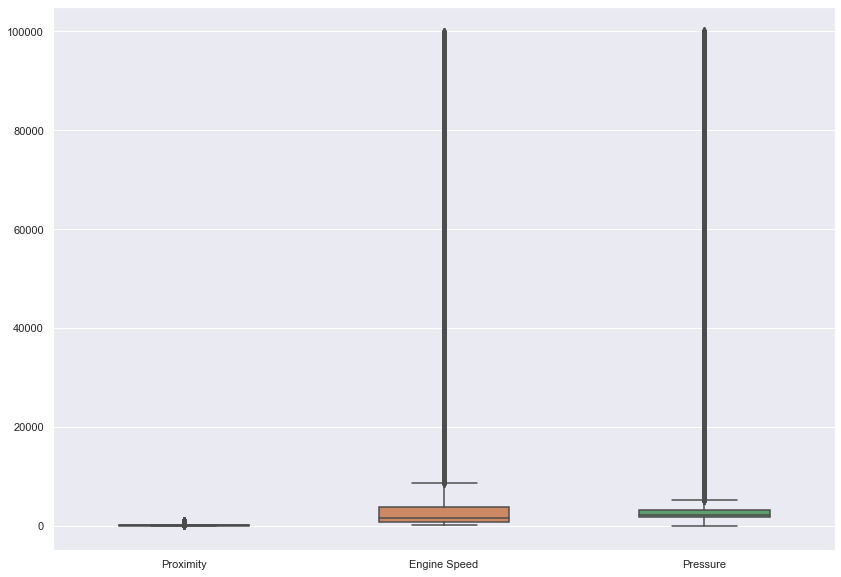

In [30]:
sns.set(rc={'figure.figsize':(14,10)})
sns.boxplot(data = data, width = 0.5, showfliers = True)

<AxesSubplot: xlabel='Proximity'>

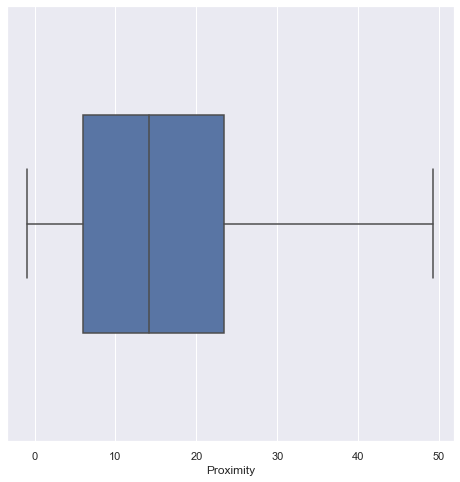

In [31]:
sns.set(rc={'figure.figsize':(8,8)})
sns.boxplot(x=data["Proximity"], width = 0.5, orient = "h", showfliers = False)

<AxesSubplot: >

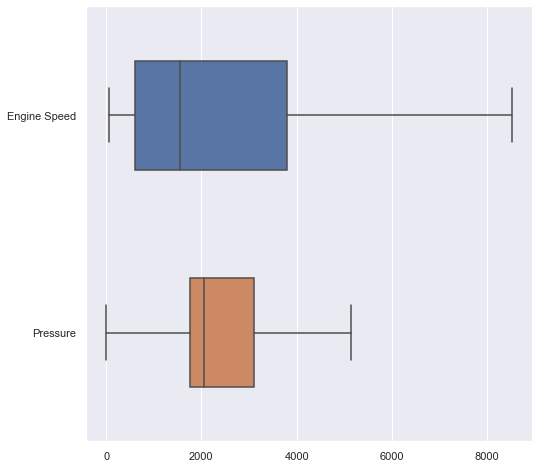

In [32]:
sns.set(rc={'figure.figsize':(8,8)})
sns.boxplot(data=data[["Engine Speed", "Pressure"]], width = 0.5, orient = "h", showfliers = False)

<i>Assessment:</i>

While there are no missing values, many outliers are noticeable in the visualizations - therefore, some of the intentionally generated anomalies can already be detected at this stage. When displaying the boxplots with the basic built-in outlier removal of the "seaborn" package enabled, it is visible that the data distribution does not correspond exactly to the range of valid values defined for our sensors (Proximity: 3.0-30.0 millimeters, Engine speed: 500-7000 RPM, Pressure: 1500-6000 bar), indicating the presence of anomalies that could not easily be detected as outliers because they are relatively close to the correct values. Additionally, the analysis shows that not every value is unique, with duplicate values occurring within one attribute as well as for combinations of two or even three attributes. However, this is not an issue and not unrealistic given the data types and the limited range of possible values for the attributes.

### Data preparation

Since the data was generated for our specific purpose, we don't need to take most of the usual steps of data preparation. However, we still outline the process and some example methods below as with real data, it will most likely be necessary.

<i>Selection:</i>

In case this was necessary, the pandas "loc", "iloc" and "at" operators would be useful.

<i>Cleaning:</i>

At this point, rows with only null values (if there were any) could be dropped, like shown below.

In [33]:
#data = data.dropna()

<i>Construction:</i>

If there were multiple datasets with differing attribute names or other differences, these would be renamed and joined or handled in another appropriate way at this stage, see example methods below.

In [34]:
#data.columns = ["column1", "column2", "column3"]
#data = pd.concat([data_subset1, data_subset2], ignore_index = True)

<i>Reduction:</i>

At this stage, unneccessary / irrelevant data would be removed - for example, unwanted values could be identified and removed or replaced by other defined values, see example methods below.

In [35]:
#data["column"].unique()
#data = data.drop(data[data["column"] == 'unwanted_value'].index)
#data.loc[(data["column"] == 'value_to_be_replaced'), 'column'] = new_value


<i>Formatting:</i>

As a final step before the modeling begins, the dataset could be formatted (if necessary) by renaming or rearranging columns, resetting the index or carrying out similar common actions.

### Modeling

<i>Technique:</i>

We are dealing with labeled data and are therefore using classification methods. Of the available techniques to chose from, we have opted for these:

* Logistic Regression
* Support Vector Machine
* Random Forest
* Neural Network (Multi-layer Perceptron)

To find the best solution, we are training four different models and are comparing their performance.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

<i>Test design:</i>

We are dividing the dataset into a training dataset and a test dataset, using the common 80/20 split.

In [37]:
X = data.loc[:, ["Proximity", "Engine Speed", "Pressure"]]
y = data["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=99)
test_data = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1)

<i>Building:</i>

Next up, we are training the four models on the training dataset before they make predictions on the data of the test dataset.

In [38]:
# Logistic regression
lr_model = LogisticRegression(solver='lbfgs', multi_class='auto')
lr_model.fit(X_train, y_train)
test_data["Logistic Regression"] = lr_model.predict(X_test)

# Support Vector Machine
svm_model = svm.LinearSVC(dual = False)
svm_model.fit(X_train, y_train)
test_data["Support Vector Machine"] = svm_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
test_data["Random Forest"] = rf_model.predict(X_test)

# Neural Network (Multi-layer Perceptron)
nn_model = MLPClassifier(hidden_layer_sizes=(4, 4, 4, 4, 3), max_iter = 500, solver='adam', random_state=44)
nn_model.fit(X_train, y_train)
test_data["Neural Network"] = nn_model.predict(X_test)

<i>Assessment:</i>

Logistic Regression:

In [39]:
y_prediction_lr = test_data["Logistic Regression"]
y_actual = test_data["Label"]
confusion_matrix_lr = pd.crosstab(y_prediction_lr, y_actual)
confusion_matrix_lr

Label,anomaly,correct
Logistic Regression,,
anomaly,3096,0
correct,4129,232775


In [40]:
print(f'Accuracy: {round(accuracy_score(y_actual, y_prediction_lr) * 100, 2)}%')
print(f'Precision: {round(precision_score(y_actual, y_prediction_lr, pos_label="anomaly") * 100, 2)}%')
print(f'Recall: {round(recall_score(y_actual, y_prediction_lr, pos_label="anomaly") * 100, 2)}%')
print(f'F1 Score: {round(f1_score(y_actual, y_prediction_lr, pos_label="anomaly") * 100, 2)}%')

Accuracy: 98.28%
Precision: 100.0%
Recall: 42.85%
F1 Score: 59.99%


Support Vector Machine:

In [41]:
y_prediction_svm = test_data["Support Vector Machine"]
y_actual = test_data["Label"]
confusion_matrix_svm = pd.crosstab(y_prediction_svm, y_actual)
confusion_matrix_svm

Label,anomaly,correct
Support Vector Machine,,
anomaly,2845,0
correct,4380,232775


In [42]:
print(f'Accuracy: {round(accuracy_score(y_actual, y_prediction_svm) * 100, 2)}%')
print(f'Precision: {round(precision_score(y_actual, y_prediction_svm, pos_label="anomaly") * 100, 2)}%')
print(f'Recall: {round(recall_score(y_actual, y_prediction_svm, pos_label="anomaly") * 100, 2)}%')
print(f'F1 Score: {round(f1_score(y_actual, y_prediction_svm, pos_label="anomaly") * 100, 2)}%')

Accuracy: 98.18%
Precision: 100.0%
Recall: 39.38%
F1 Score: 56.5%


Random Forest:

In [43]:
y_prediction_rf = test_data["Random Forest"]
y_actual = test_data["Label"]
confusion_matrix_rf = pd.crosstab(y_prediction_rf, y_actual)
confusion_matrix_rf

Label,anomaly,correct
Random Forest,,
anomaly,6404,7
correct,821,232768


In [44]:
print(f'Accuracy: {round(accuracy_score(y_actual, y_prediction_rf) * 100, 2)}%')
print(f'Precision: {round(precision_score(y_actual, y_prediction_rf, pos_label="anomaly") * 100, 2)}%')
print(f'Recall: {round(recall_score(y_actual, y_prediction_rf, pos_label="anomaly") * 100, 2)}%')
print(f'F1 Score: {round(f1_score(y_actual, y_prediction_rf, pos_label="anomaly") * 100, 2)}%')

Accuracy: 99.66%
Precision: 99.89%
Recall: 88.64%
F1 Score: 93.93%


Neural Network (Multi-layer Perceptron):

In [45]:
y_prediction_nn = test_data["Neural Network"]
y_actual = test_data["Label"]
confusion_matrix_nn = pd.crosstab(y_prediction_nn, y_actual)
confusion_matrix_nn

Label,anomaly,correct
Neural Network,,
anomaly,4760,35
correct,2465,232740


In [46]:
print(f'Accuracy: {round(accuracy_score(y_actual, y_prediction_nn) * 100, 2)}%')
print(f'Precision: {round(precision_score(y_actual, y_prediction_nn, pos_label="anomaly") * 100, 2)}%')
print(f'Recall: {round(recall_score(y_actual, y_prediction_nn, pos_label="anomaly") * 100, 2)}%')
print(f'F1 Score: {round(f1_score(y_actual, y_prediction_nn, pos_label="anomaly") * 100, 2)}%')

Accuracy: 98.96%
Precision: 99.27%
Recall: 65.88%
F1 Score: 79.2%


### Evaluation

To better assess and interpret the calculated scores, it is helpful to remember some definitions:

TP = True Positives (predicted class positive, actual class positive) <br>
TN = True Negatives (predicted class negative, actual class negative) <br>
FP = False Positives (predicted class positive, actual class negative) <br>
FN = False Negatives (predicted class negative, actual class positive) <br>

$ Accuracy = {TP + TN \over TP + FP + TN + FN}$ <br>

$ Precision = {TP \over TP + FP}$ <br>

$ Recall = {TP \over TP + FN}$ <br>

$ F1 Score = {2 * {Precision * Recall \over Precision + Recall}}$ <br>

For the interpretation of the scores, it is important to keep in mind the following aspects:

1. According to the decision matrices, all four methods predict the actually correct values almost perfectly as correct.
2. The matrices also show that predictions of the anomalies are not as successful, with big differences between the methods.
3. Errors are mostly (non-detected) anomalies predicted as correct values (False Negatives), but hardly any correct values predicted as anomalies (False Positives).
4. The correct rows make up 97% of all rows in the dataset, while the anomalies account for 3%.

For all ML methods, accuracy and precision are high (>98%), while for the recall and precision, high values around 90% are only reached by the Random Forest model. Why is this the case?

* The accuracy calculates the share of true predictions among all predictions - it is high because of the dataset's value distribution - see aspect 4 (and 1) above.
* For the precision, recall, and F1 score, the positive class was specifically set to "anomaly" so that the target for defining TP/TN/FP/FN is clear:
    * The precision is high because there are hardly any False Positives - see aspect 3 above.
    * The recall is generally lower because it considers False Negatives - see aspect 3 above.
    * Since the F1 score is dependent on the recall, it is lower too.

After evaluating the different ML models, it is clear that for our purposes, the Random Forest model is the most suitable choice due to its vastly superior performance.

Therefore, we will now save/persist our trained Random Forest model to use it for anomaly detection later.

Persisting the model:

In [47]:
import skops.io as sio

# File name to be used
file_name = "data/trained_model.skops"

# Persist the model to a file
sio.dump(obj = rf_model, file = file_name)

# Load the model from the file
trained_model = sio.load(file = file_name, trusted = True)
print(trained_model)

# Optional: for security reasons, first check the data types before loading the file
# data_types = sio.get_untrusted_types(file = file_name)
# print(data_types)
# trained_model = sio.load(file = file_name, trusted = data_types)
# print(trained_model)

RandomForestClassifier()


### Deployment

Before the model can be used in practice, we will define two convenient functions. First, train_model() combines all of the previously shown code related to training the model:

In [48]:
# Function to train a random forest model
def train_model(data):
    # Import libraries
    import pandas as pd
    import seaborn as sns
    from sklearn.linear_model import LogisticRegression
    from sklearn import svm
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

    # Load data
    data = pd.read_csv(data)

    # Select attributes
    X = data.loc[:, ["Proximity", "Engine Speed", "Pressure"]]
    y = data["Label"]

    # Split data in training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=99)
    test_data = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1)

    # Train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100)
    rf_model.fit(X_train, y_train)

    # Make predictions
    test_data["Random Forest"] = rf_model.predict(X_test)

    # Evaluation: create a confusion matrix
    y_prediction_rf = test_data["Random Forest"]
    y_actual = test_data["Label"]
    confusion_matrix_rf = pd.crosstab(y_prediction_rf, y_actual)
    # Outside of Jupyter, use print() instead of display()
    display(confusion_matrix_rf)

    # Evaluation: calculate performance metrics
    print(f'Accuracy: {round(accuracy_score(y_actual, y_prediction_rf) * 100, 2)}%')
    print(f'Precision: {round(precision_score(y_actual, y_prediction_rf, pos_label="anomaly") * 100, 2)}%')
    print(f'Recall: {round(recall_score(y_actual, y_prediction_rf, pos_label="anomaly") * 100, 2)}%')
    print(f'F1 Score: {round(f1_score(y_actual, y_prediction_rf, pos_label="anomaly") * 100, 2)}%')

Secondly, detect_anomalies() loads a trained model and uses it on unseen data to predict anomalies:

In [49]:
# Function to apply the trained model and make predictions
def detect_anomalies(data_row):
    # Load libraries
    import skops.io as sio

    # Load the model from the file
    trained_model = sio.load(file = "data/trained_model.skops", trusted = True)

    # Make prediction and print result
    if(trained_model.predict(data_row) == "correct"):
        print("No anomaly was detected ✅")
        return "correct"
    else:
        print("An anomaly was detected ❌")
        return "anomaly"

Let's try out the function on two example data rows, one we know is correct and one we know is an anomaly:

In [50]:
data = pd.read_csv("data/data.csv")

correct_data_row = data.loc[0:0, ["Proximity", "Engine Speed", "Pressure"]]
anomaly_data_row = data.loc[36:36, ["Proximity", "Engine Speed", "Pressure"]]

test_1 = detect_anomalies(correct_data_row)
test_2 = detect_anomalies(anomaly_data_row)

No anomaly was detected ✅
An anomaly was detected ❌


As we can see, the detection of anomalies behaves as expected in these two example cases.